Digital Business University of Applied Sciences

Data Science und Management (M. Sc.)

MALE01 Machine Learning

Prof. Dr. Daniel Ambach

Julia Schmid (200022)

***
# Vergleich datenbasierter und algorithmusbasierter Methoden zur Behebung unausgeglichener Datensätze in Klassifikationsmodellen am Beispiel der Zahlungsausfallvorhersage
***

In diesem Jupyter-Notebook werden ausgewählte datenbasierte und modellbasierte Methoden zur Behebung von unausgeglichenen Datensätzen auf die Machine Learning (ML) Klassifikationsmodelle Random Forest, Logistische Regression und XGBoost angewendet. Anschließend werden die Modelle auf den einzelnen Methoden evaluiert und mireinander verglichen, um die Wirksamkeit datenbasierter im Vergleich zu algorithmischer Verfahren herauszuarbeiten.

**Problemstellung**

In Datensätzen tritt häufig das Problem auf, dass eine starke Ungleichverteilung der Zielvariable vorliegt. Dies kann unterschiedliche Ursachen haben, wie etwa natürliche Häufigkeiten, fehlerhafte Datenerhebung oder Verzerrungen in der Datenerhebung. In der Minderheitsklasse können elementar wichtige Informationen stecken, wie seltene medizinische Diagnosen. Durch die ungleichmäßige Klassenverteilung kann das bei Klassifikationsproblemen zu verzerrten Ergebnissen führen, wodurch bestimmte Gruppen systematisch benachteiligt werden und somit die Fairness des Modells beeinträchtigen. 

In [41]:
# Importe
# Standardbibliotheken
import os
import pandas as pd 
from collections import Counter

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Modelle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metriken
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,roc_curve, auc, balanced_accuracy_score)

# Sampling Methoden
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Profilingreport
from ydata_profiling import ProfileReport
import webbrowser


**Datenauswahl**

Für den Vergleich der datenbasierte und algorithmusbasierte Methoden wurde Datensatz Give Me Some Credit (Fusion & Cukiersk, 2011) von Kaggel verwendet. Dieser Datensatz beinhaltet zwölf Variablen mit verschiedenen Kreditinformationen von 150.000 Bankkunden. Zudem liefert die Zielvaribale (SeriousDlqin2yrs) Information darüber, ob ein Zahlungsverzug von mindestens 90 Tagen eingetreten ist. Bei dieser Zielvariable ist die Klasse "kein Zahlungsausfall" deutlich überrepäsentiert im Vergleich zu der Klasse "Zahlungsausfall". Vor diesem Hintergrund bietet sich dieser Datensatz dafür an, die datenbasierte und algorithmusbasierte Methoden auf den Datensatz anzuwenden, zu evlauieren und zu vergleichen. 


## **Daten verstehen** 

### Daten einlesen

In [42]:
input_file_name = "input/cs-training.csv"
df = pd.read_csv(input_file_name, encoding='latin1', index_col=0)

### Daten beschreiben

In [43]:
# Ausgabe der ersten 5 Zeilen
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [44]:
# Ausgabe der Anzahl der Zeilen und Spalten
print(f'Anzahl Zeilen: {df.shape[0]}')
print(f'Anzahl Spalten: {df.shape[1]}')

Anzahl Zeilen: 150000
Anzahl Spalten: 11


In [45]:
# Ausgabe der Datensatz-Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

In [46]:
# Ausgabe der numerischen und kategorischen Variablen 
numericalVar = [col for col in df if df[col].dtype != 'object']
print(numericalVar)

categoricalVar = [col for col in df if df[col].dtype == 'object']
print(categoricalVar)

['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
[]


In [47]:
# Ausgabe der statistischen Kennzahlen der numerischen Variablen
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


### Daten visualisieren

In [48]:
# Erstellung eines Profilingreports
pr = ProfileReport(df, title = 'Credit Data') 
filename_pr = "output/credit_data_pr.html" 
path_pr = os.path.abspath(filename_pr) 

pr.to_file(path_pr)  # ProfileReport als HTML speichern
webbrowser.open(f"file://{path_pr}")  # ProfileReport im Browser öffnen

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 15.07it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

True

## **Datenaufbereitung**

Aus den Abschnitt "Daten Verstehen" geht hervor, dass allle Variablen numerisch sind und somit keine Transformation benötigen. 
Ferner wird der Datensatz auf Duplikate und NaN-Werte geprüft. 

### Duplikate

In [49]:
# Bestimmung der Anzahl der Duplikate
df_duplicates = df[df.duplicated()]
print(f'Dieser Datensatz besitz {len(df_duplicates)} Duplikate.')

# Bestimmung der Anzahl der Duplikate pro Klasse
duplicates_per_class = df_duplicates['SeriousDlqin2yrs'].value_counts()
print(f'Von den Duplikaten liegen {duplicates_per_class.get(0, 0)} Instanzen in der Klasse "kein Zahlungsausfall" (0) und {duplicates_per_class.get(1, 0)} Instanzen in der Klasse "Zahlungsausfall" (1)')

Dieser Datensatz besitz 609 Duplikate.
Von den Duplikaten liegen 592 Instanzen in der Klasse "kein Zahlungsausfall" (0) und 17 Instanzen in der Klasse "Zahlungsausfall" (1)


In [50]:
# Duplikate werden gelöscht
df = df.drop_duplicates()

### NaNs

In [51]:
# Bestimmung der Variablen mit Nan-Werte mit der Anzahl der NaN-Einträge
df.isnull().sum()[df.isnull().sum() > 0]

MonthlyIncome         29221
NumberOfDependents     3828
dtype: int64

In [52]:
# Zeilen mit NaN-Werten werden gelöscht, da keine Informationen darüber vorliegen, wie die fehlenden Werte sinnvoll rekonstruiert werden könnten.
df = df.dropna(subset=['MonthlyIncome'])
df = df.dropna(subset=['NumberOfDependents'])

## **Machine Learning Modellierung** 

### Funktionen für das Training und der Evaluierung der ML-Modelle



In [53]:
# Ergebnistabelle initialisieren (für die Speicherung der Evaluationskennzahlen)
df_result = pd.DataFrame(columns=['model','method', 'balancedAccuracy', 'precision', 'recall', 'f1', 'rocAuc'])

'''
Funktion:       Training auf den Trainingsdaten und Vorhersage der Zielvariable auf den Testdaten für das übergebene Modell.
Input:          ml_model (ausgewähltes zu trainierenden Modell), 
                X_train (Label der Trainingsdaten), 
                y_train (Feature der Trainingsdaten), 
                X_test (Label der Testdaten), 
                name (Name des zu trainierenden Modells), 
                algoAdaption (Variable, welche angibt, ob eine Klassen-Gewichtung bestimmt werden soll)
                threshold (Schwellenwert für die Zuordnung einer Beobachtung zu einer bestimmeten Klasse)
Output:         y_pred_model (vom Modell vorhergesagte Zielvariable)
Funktionsweise: Das übergebende Modell wird auf den Trainingsdaten trainiert und eine Vorhersage für die Testdaten getroffen. '
'''
def runModel(ml_model, X_train, y_train, X_test, name, algoAdaption = False, threshold = 0.5):
    name_print_out = name
    print('[INFO] Model ' + name_print_out + ' started.') # Info-Meldung: Modelltraining Start

    # Modell-Name
    name = name.split()[0]
    name = name.replace(" ", "")

    sampleWeights = compute_sample_weight(class_weight='balanced', y=y_train) if algoAdaption else None # Gewichtigung für das Training
    ml_model.fit(X_train, y_train, sample_weight = sampleWeights) # Modell Training mit Trainings-daten 
    
    # Für die Testdaten wird eine Vorhersage basierend auf dem trainierten Modell getroffen:
    y_proba = ml_model.predict_proba(X_test)[:, 1] 
    y_pred_model = (y_proba >= threshold).astype(int)

    print('[INFO] Model ' + name_print_out + ' finished.') # Info-Meldung: Modelltraining Ende

    return(y_pred_model)

'''           
Funktion:       Bestimmung der Evaluationskenntzahlen für das übergebende Modell 
Input:          y_pred_model (vorhergesagte Zielvariable), 
                y_test (tatsächlicher Zielvariable), 
                name (Name des trainierte Modell), 
                df_result (Ergebnistabelle), 
                method (Methode zur Behebung unausgeglichener Daten)
Output:         df_result (angepasste Ergebnistabelle), 
                (fpr, tpr, rocAuc) (ROC-Daten)
Funktionsweise: Mithilfe der vorhergesagten und der tatsächlichen Zielvariablen wird die Balanced Accuracy, Precision, Recall, F1, ROC-AUC, FPR und TPR ermittelt. 
                Die Kennzahlen werden in der Ergebistabelle mit dem Modellname und der Methodenname gespeichert.
'''
def getResults(y_pred_model, y_test, name, df_result, method):
    # Bestimmung der Evaluationskennzahlen
    balancedAccuracy = balanced_accuracy_score(y_test, y_pred_model)
    precision = precision_score(y_test, y_pred_model)
    recall = recall_score(y_test, y_pred_model)
    f1 = f1_score(y_test, y_pred_model)
    rocAuc = roc_auc_score(y_test, y_pred_model)
    fpr, tpr, _ = roc_curve(y_test, y_pred_model)
    rocAuc = auc(fpr, tpr)

    # Speicherung der Evaluationskennzahlen 
    temp = pd.DataFrame([[name.split()[0], method, balancedAccuracy, precision, recall, f1,rocAuc ]], columns=['model','method','balancedAccuracy', 'precision', 'recall', 'f1', 'rocAuc'])
    df_result = pd.concat([df_result, temp], ignore_index=True)

    return df_result, (fpr, tpr, rocAuc)

'''
Funktion:       Definierung der ML-Modelle inkl. Methode-Besonderheiten sowie Training und Evaluierung der Modelle
Input:          X_train (Label der Trainingsdaten), 
                y_train (Feature der Trainingsdaten), 
                X_test (Label der Testdaten), 
                y_test (tatsächlicher Zielvariable), 
                df_result (Ergebnistabelle), 
                method (Methode zur Behebung unausgeglichener Daten), 
                balanced (Gewicht-Parameter-Wert), 
                algo (Boolean-Wert der angibt, ob es sich um die Anpassung der Parameter Methode handelt)
                threshold (Schwellenwert für die Zuordnung einer Beobachtung zu einer bestimmeten Klasse)
Output:         df_result (angepasste Ergebnistabelle), 
                roc_data_dict (ROC-Daten)
Funktionsweise: Abhängig von der Anpassung der Parameter Methode wird das Klassenverhätlnis für das XGBoost-Modell bestimmt. 
                Anschließend werden die Modelle mit ihren Methode-Besonderheiten definiert. Jedes Modell wird trainiert, getestet und evaluiert.
'''
def runAndPredict(X_train, y_train, X_test, y_test, df_result, method, balanced = None, algo = False, threshold = 0.5):
    # Bei der Methode der Anpassung der Parameter wird das Verhältnis der beiden Zielvariablenklassen (0,1) bestimmt. 
    # Bei allen anderen Methoden wird keine Verhältnis bestimmt und auf 1 gesetzt.
    ratio = 1 if algo == False else (sum(y_train == 0) / sum(y_train == 1))
    if(ratio != 1):
        print(f'Das Klassenverhältnis beträgt: {ratio}')

    # Definierung der drei ML-Grundmodelle
    rf_model = RandomForestClassifier(random_state=123, class_weight = balanced)
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric = 'auc', random_state=123, n_estimators=500, learning_rate=0.2, scale_pos_weight=ratio )
    logReg_model = LogisticRegression(class_weight=balanced)

    # Zuordnung zwischen Modell-Name (mit Methoden-Besonderheit) und Modell
    ml_model = {
        f'RF {method}': rf_model,
        f'XGBoost {method}': xgb_model,
        f'LR {method}': logReg_model
    }
    
    roc_data_dict = {}

    # Jedes Model wird trainiert und evaluiert
    for modelName, model in ml_model.items():
        y_pred = runModel(model, X_train, y_train, X_test, modelName, threshold = threshold) # Training und Vorhersage der Zievariable auf Testdaten
        df_result, roc_data = getResults(y_pred, y_test, modelName, df_result, method) # Evaluierung 
        roc_data_dict[modelName] = roc_data # Speicherung der ROC-Daten

    return df_result, roc_data_dict

### Daten in Test- und Trainingsdaten teilen

In [54]:
# Ausgabe der Verteilung der Zielvariable SeriousDlqin2yrs
count_label = df['SeriousDlqin2yrs'].value_counts()
count_label

SeriousDlqin2yrs
0    111815
1      8355
Name: count, dtype: int64

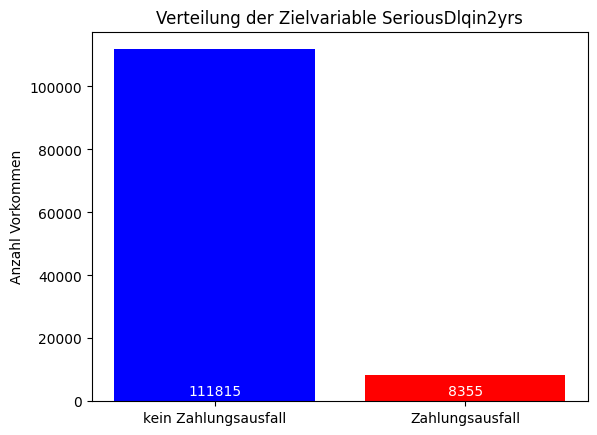

In [55]:
# Grafik: Verteilung der Zielvariable SeriousDlqin2yrs
plt.bar(count_label.index, count_label.values, color=['blue', 'red'])
plt.xlabel('')
plt.ylabel('Anzahl Vorkommen')
plt.title('Verteilung der Zielvariable SeriousDlqin2yrs')
plt.xticks(ticks=[0, 1], labels=["kein Zahlungsausfall", "Zahlungsausfall"])
y_text_position = min(count_label.values) * 0.1
for i, v in enumerate(count_label.values):
    plt.text(i, y_text_position, str(v), ha='center', va='bottom', color='white', fontsize=10)
plt.savefig("output/distribution_targetVariable.png", dpi=300, bbox_inches="tight")
plt.show()

In [56]:
# Daten im Verhätlnis 80%-20% (Training-Test) aufteilen
y = df['SeriousDlqin2yrs']
X = df.loc[:,df.columns != 'SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [57]:
# Skalierung 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Basismodell**

In [58]:
# Anwendung der Funktion runAndPredict ohne Anpassungenm 
df_result, roc_data = runAndPredict(X_train_scaled, y_train, X_test_scaled, y_test, df_result, 'Baseline' )

[INFO] Model RF Baseline started.
[INFO] Model RF Baseline finished.
[INFO] Model XGBoost Baseline started.


/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_35671/2324340301.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, temp], ignore_index=True)


[INFO] Model XGBoost Baseline finished.
[INFO] Model LR Baseline started.
[INFO] Model LR Baseline finished.


### **Algorithm-Level** 

#### Anpassung der Hyperparameter

In [59]:
# Anwendung der Funktion runAndPredict mit angepassten Hyperparameter 
df_result, roc_data_hp = runAndPredict(X_train_scaled, y_train, X_test_scaled, y_test, df_result, 'HP', balanced = "balanced",algo = True )

Das Klassenverhältnis beträgt: 13.34437481348851
[INFO] Model RF HP started.
[INFO] Model RF HP finished.
[INFO] Model XGBoost HP started.
[INFO] Model XGBoost HP finished.
[INFO] Model LR HP started.
[INFO] Model LR HP finished.


#### Threshold Moving

In [60]:
# Anwendung der Funktion runAndPredict mit angepassten Treshold
df_result, roc_data_tm = runAndPredict(X_train_scaled, y_train, X_test_scaled, y_test, df_result, 'TM', threshold = 0.3)

[INFO] Model RF TM started.
[INFO] Model RF TM finished.
[INFO] Model XGBoost TM started.
[INFO] Model XGBoost TM finished.
[INFO] Model LR TM started.
[INFO] Model LR TM finished.


### **Data-Level**

### Undersampling

#### Random Undersampling

In [61]:
# Undersampling durchführen
print('Ursprüngliche Klassenvertilung %s' % Counter(y))

rus = RandomUnderSampler(random_state=123)
X_rus, y_rus = rus.fit_resample(X, y)

print('Neue Klassenverteilung mit Undersampling:', Counter(y_rus))
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size = 0.2, random_state = 123)

Ursprüngliche Klassenvertilung Counter({0: 111815, 1: 8355})
Neue Klassenverteilung mit Undersampling: Counter({0: 8355, 1: 8355})


In [62]:
# Skalierung 
scaler = StandardScaler()
X_train_rus_scaled = scaler.fit_transform(X_train_rus)
X_test_rus_scaled = scaler.transform(X_test_rus)

In [63]:
# Anwendung der Funktion runAndPredict mit Undersampling
df_result, roc_data_rus = runAndPredict(X_train_rus_scaled, y_train_rus, X_test_rus_scaled, y_test_rus, df_result, 'RUS')

[INFO] Model RF RUS started.
[INFO] Model RF RUS finished.
[INFO] Model XGBoost RUS started.
[INFO] Model XGBoost RUS finished.
[INFO] Model LR RUS started.
[INFO] Model LR RUS finished.


#### Tomek Links

In [64]:
print('Ursprüngliche Klassenvertilung %s' % Counter(y))


tl = TomekLinks(sampling_strategy='majority')  # Nur Mehrheitsklasse wird reduziert
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)

print('Neue Klassenverteilung mit Tomek Links:', Counter(y_train_tl))

Ursprüngliche Klassenvertilung Counter({0: 111815, 1: 8355})
Neue Klassenverteilung mit Tomek Links: Counter({0: 87222, 1: 6702})


In [65]:
# Skalierung 
scaler = StandardScaler()
X_train_tl_scaled = scaler.fit_transform(X_train_tl)
X_test_tl_scaled = scaler.transform(X_test)

In [66]:
# Anwendung der Funktion runAndPredict mit SMOTE
df_result, roc_data_tl = runAndPredict(X_train_tl_scaled, y_train_tl, X_test_tl_scaled, y_test, df_result, 'TL')

[INFO] Model RF TL started.
[INFO] Model RF TL finished.
[INFO] Model XGBoost TL started.
[INFO] Model XGBoost TL finished.
[INFO] Model LR TL started.
[INFO] Model LR TL finished.


### Oversampling

#### Random Undersampling

In [67]:
# Oversampling durchführen 
print('Ursprüngliche Klassenvertilung %s' % Counter(y))

ros = RandomOverSampler(sampling_strategy='minority')
X_ros, y_ros = ros.fit_resample(X, y)

print('Neue Klassenverteilung mit Oversampling:', Counter(y_ros))

X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size = 0.2, random_state = 123)

Ursprüngliche Klassenvertilung Counter({0: 111815, 1: 8355})
Neue Klassenverteilung mit Oversampling: Counter({1: 111815, 0: 111815})


In [68]:
# Skalierung 
scaler = StandardScaler()
X_train_ros_scaled = scaler.fit_transform(X_train_ros)
X_test_ros_scaled = scaler.transform(X_test_ros)

In [69]:
# Anwendung der Funktion runAndPredict mit Oversampling
df_result, roc_data_ros = runAndPredict(X_train_ros_scaled, y_train_ros, X_test_ros_scaled, y_test_ros, df_result, 'ROS' )

[INFO] Model RF ROS started.
[INFO] Model RF ROS finished.
[INFO] Model XGBoost ROS started.
[INFO] Model XGBoost ROS finished.
[INFO] Model LR ROS started.
[INFO] Model LR ROS finished.


#### SMOTE

In [70]:
# SMOTE durchführen
print('Ursprüngliche Klassenvertilung %s' % Counter(y))

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Neue Klassenverteilung mit SMOTE:', Counter(y_train_smote))


Ursprüngliche Klassenvertilung Counter({0: 111815, 1: 8355})
Neue Klassenverteilung mit SMOTE: Counter({0: 89434, 1: 89434})


In [71]:
# Skalierung 
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_smote_scaled = scaler.transform(X_test)

In [72]:
# Anwendung der Funktion runAndPredict mit SMOTE
df_result, roc_data_smote = runAndPredict(X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test, df_result, 'SMOTE')

[INFO] Model RF SMOTE started.
[INFO] Model RF SMOTE finished.
[INFO] Model XGBoost SMOTE started.
[INFO] Model XGBoost SMOTE finished.
[INFO] Model LR SMOTE started.
[INFO] Model LR SMOTE finished.


## **Evaluation**

### Vergleich der Evaluationskennzahlen (Tabelle)

In [73]:
df_result = df_result.sort_values(by='model')
df_result

,model,method,balancedAccuracy,precision,recall,f1,rocAuc
20,LR,SMOTE,0.669045,0.134265,0.645493,0.222292,0.669045
2,LR,Baseline,0.514433,0.472727,0.031458,0.058990,0.514433
17,LR,ROS,0.726348,0.786421,0.620179,0.693476,0.726348
5,LR,HP,0.721598,0.210199,0.613430,0.313108,0.721598
14,LR,TL,0.515509,0.466667,0.033878,0.063170,0.515509
8,LR,TM,0.540969,0.465409,0.089534,0.150178,0.540969
11,LR,RUS,0.723811,0.786987,0.611312,0.688114,0.723811
18,RF,SMOTE,0.680507,0.290619,0.440411,0.350168,0.680507
15,RF,ROS,0.985731,0.972101,1.000000,0.985853,0.985731
12,RF,TL,0.596299,0.516616,0.206897,0.295464,0.596299


In [74]:
df_result['ModelKind'] = df_result['model'] + '-' + df_result['method']

# Ausgabe der besten Methode pro Kennzahl
for i in ['balancedAccuracy', 'precision', 'recall', 'f1', 'rocAuc']:
    max_value_row = df_result.loc[df_result[i].idxmax()]  # Bestimme Zeile mit Maximalen-Wert
    max_value_kind = max_value_row['ModelKind']
    print(f"Maximale Wert {i} = {max_value_row[i]} beim Modell {max_value_kind}.")


Maximale Wert balancedAccuracy = 0.9857308481227147 beim Modell RF-ROS.
Maximale Wert precision = 0.972101133391456 beim Modell RF-ROS.
Maximale Wert recall = 1.0 beim Modell RF-ROS.
Maximale Wert f1 = 0.9858532272325375 beim Modell RF-ROS.
Maximale Wert rocAuc = 0.9857308481227147 beim Modell RF-ROS.


### Vergleich der Evaluationskennzahlen (Grafiken)

# 

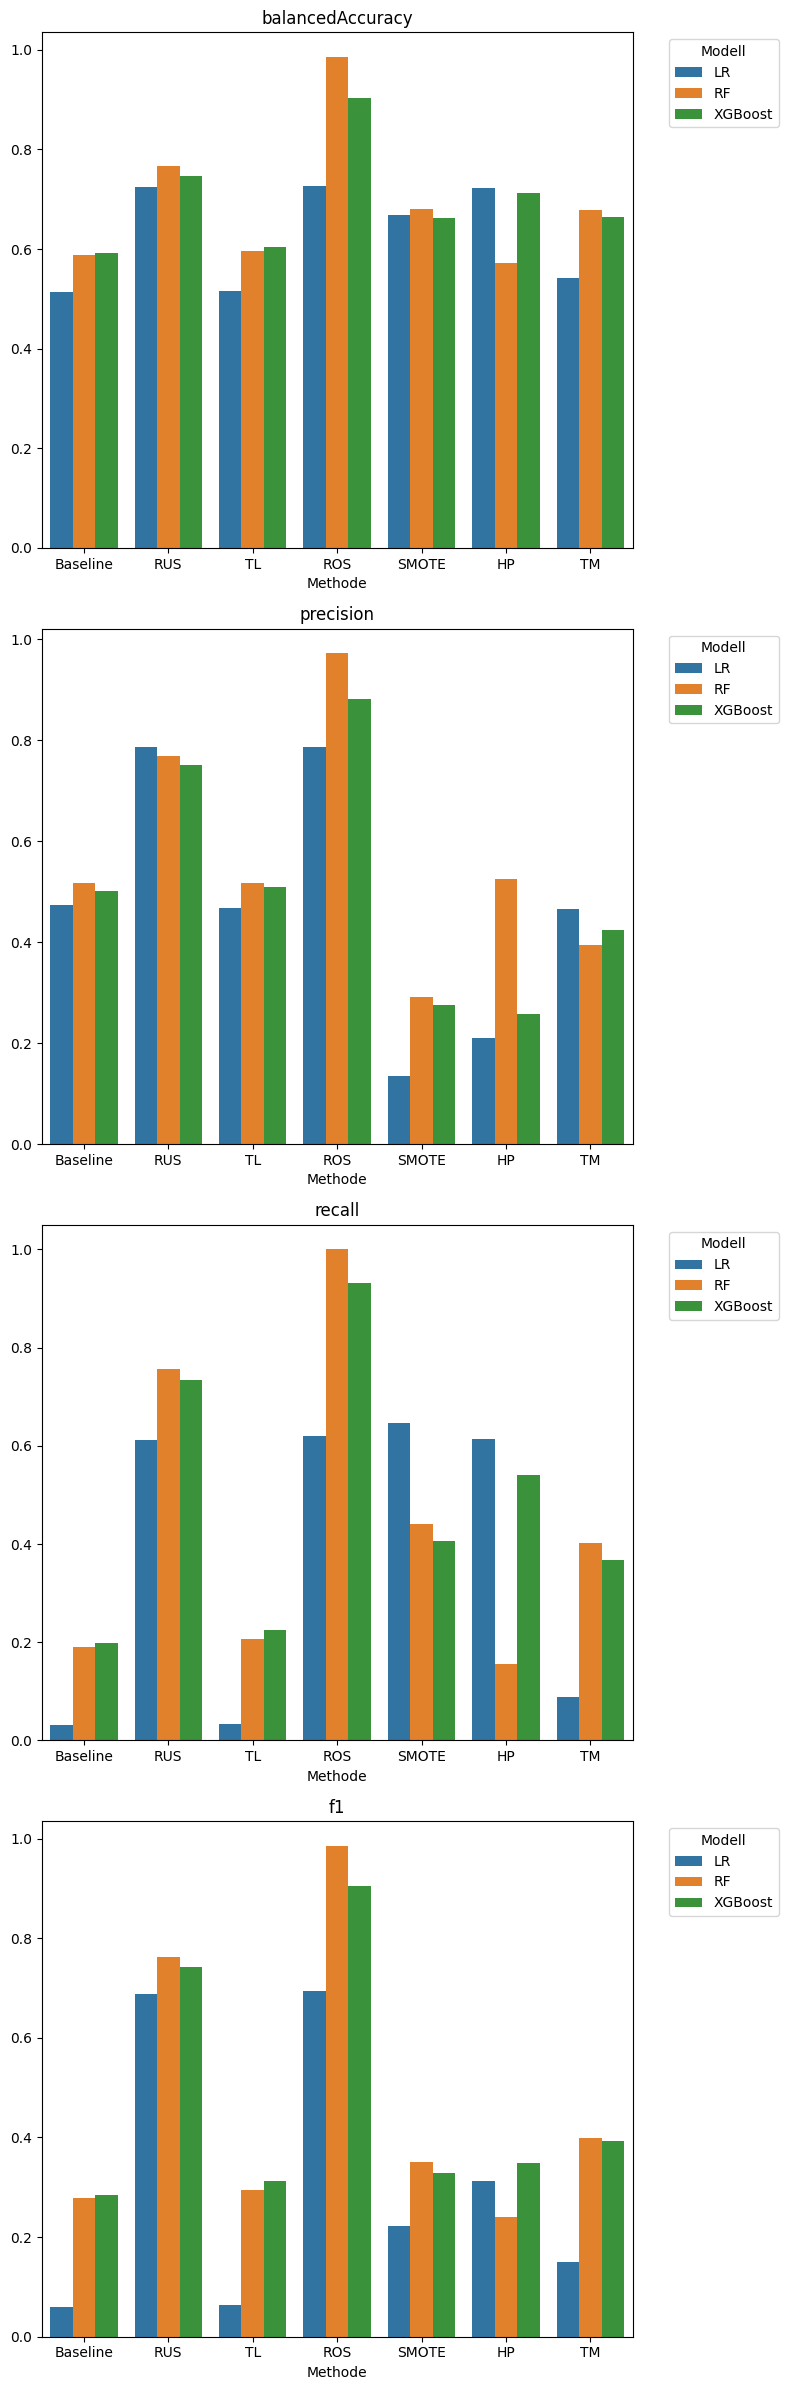

In [75]:
# Methoden-Liste
resampling_methods = ["Baseline", "RUS", "TL",  "ROS", "SMOTE", "HP", "TM", ]

# Metriken-Liste 
metrics = ["balancedAccuracy", "precision", "recall", "f1"]

# Grafiken pro Metrik
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 6 * len(metrics)))
for ax, i in zip(axes, metrics):
    sns.barplot(data=df_result, x="method", y=i, hue="model", order=resampling_methods, ax=ax)
    ax.set_title(i)
    ax.set_xlabel("Methode")
    ax.set_ylabel('')
    ax.legend(title="Modell", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# Gesamt-Grafik speichern
plt.savefig("output/evaluation_metrics.png", dpi=300, bbox_inches="tight")
plt.show()


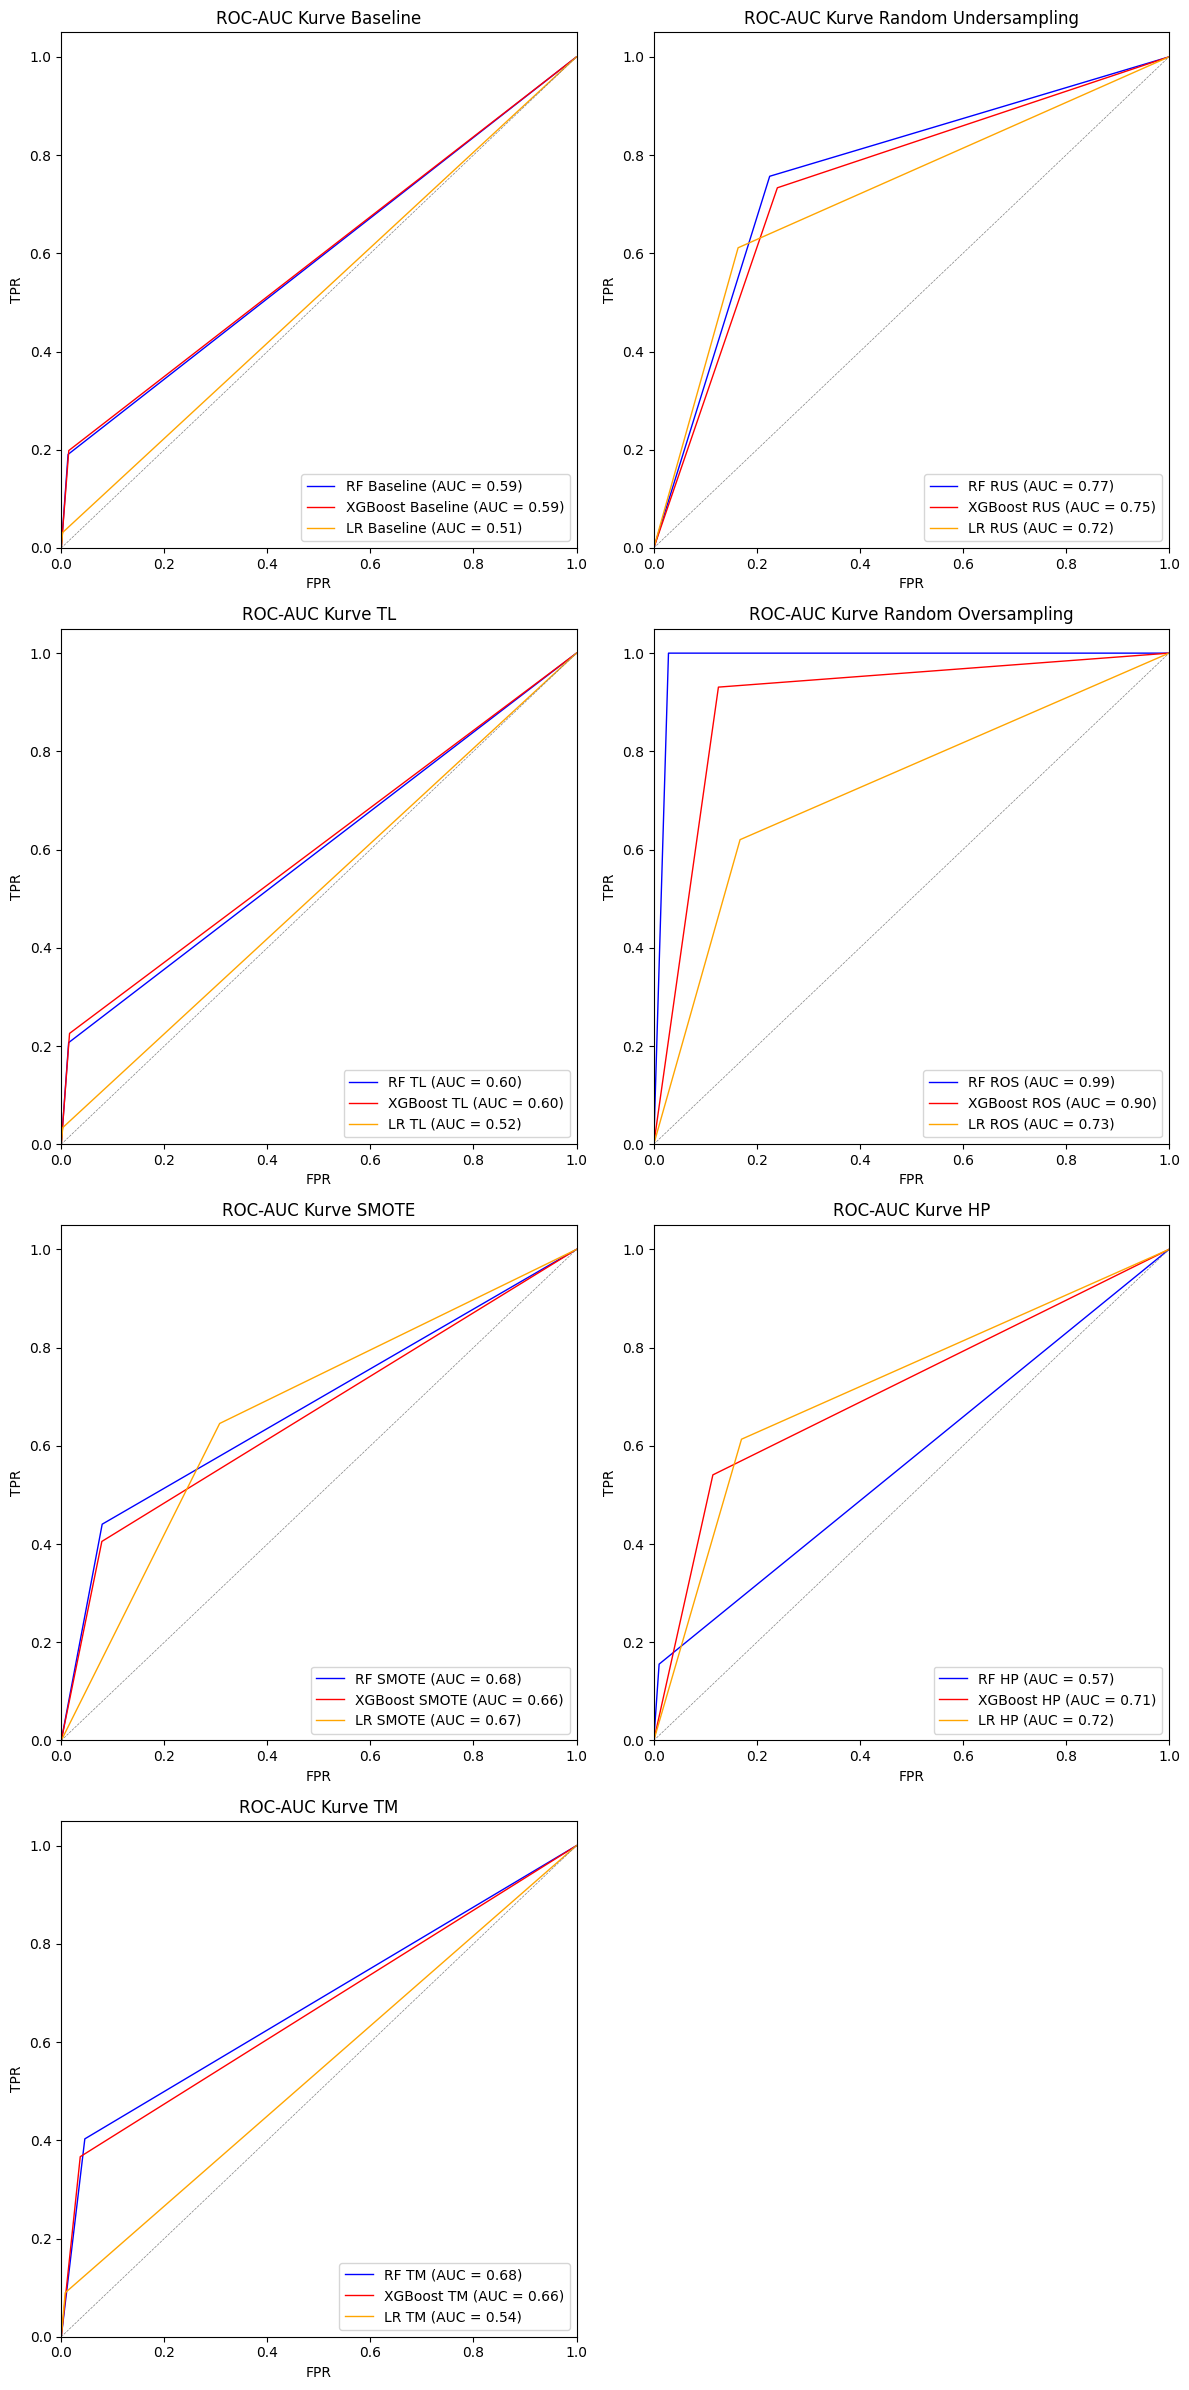

In [76]:
''' 
Funktion:       Erstellung ROC-AUC-Kurve für die verschiedenen Methoden zur Behebung unausgeglichener Daten
Input:          roc_data_list (roc_data)
                methodTitles (Methode zur Behebung unausgeglichener Daten für die Anzeige im Titel)
Funktionsweise: Basierend auf den gespeicherten ROC-Daten wird die ROC-AUC-Kurve für die drei ML-Modell pro Methode dargestellt.
'''
def plot_roc_curves(roc_data_list, methodTitles):
    num_plots = len(roc_data_list)
    num_cols = 2  
    num_rows = (num_plots + 1) // num_cols  
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    axes = axes.flatten()  
    
    # Farben der einzelnen ML-Modelle festlegen
    colors = {
        'RF': 'blue',
        'XGBoost': 'red',
        'LR': 'orange'
    }
    
    # Pro Methode werden pro Modell die dazugehörige ROC-AUC-Kurve in die Grafik eingezeichnet
    for idx, (roc_data, methodTitles) in enumerate(zip(roc_data_list, methodTitles)):
        ax = axes[idx]
        
        for model_name, (fpr, tpr, auc) in roc_data.items():
            ax.plot(fpr, tpr, color=colors.get(model_name.split()[0], 'black'), lw=1,
                    label=f'{model_name} (AUC = {auc:.2f})')
        
        ax.plot([0, 1], [0, 1], color='gray', lw=0.5, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'ROC-AUC Kurve {methodTitles}')
        ax.legend(loc="lower right")
    
    if num_plots % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    # Gesamt-Grafik speichern
    plt.savefig('output/evaluation_roc_auc.png', dpi=300, bbox_inches="tight")
    plt.show()
    

roc_data_list = [roc_data,  roc_data_rus, roc_data_tl, roc_data_ros, roc_data_smote, roc_data_hp, roc_data_tm] # ROC-Daten-Liste
titles = ['Baseline', 'Random Undersampling', "TL", 'Random Oversampling', 'SMOTE', 'HP', "TM"] # Methodennamen-Liste
plot_roc_curves(roc_data_list, titles)


resampling_methods = ["Baseline", "RUS", "TL",  "ROS", "SMOTE", "HP", "TM", ]


***
***